In [3]:
import torch
from tqdm.notebook import tqdm_notebook
import torchvision
import torchvision.transforms as transforms
import numpy as np
print(torch.cuda.is_available())

True


In [4]:
def Dataset(batch_size):
    transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
                ])

    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)
    trainset_size = len(trainset)
    
    trainset, valset = torch.utils.data.random_split(trainset, [55000, 5000])

    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True)
    
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                            shuffle=True)

    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
    
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False)
    
    return trainloader, valloader, testloader

In [5]:
train_loader, val_loader, test_loader = Dataset(32)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
import torch.nn as nn
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()

        self.c1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1,padding=2)
        self.c2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1,padding=0)
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features=16*5*5,out_features=120)
        self.fc2 = nn.Linear(in_features=120,out_features=84)
        self.fc3 = nn.Linear(in_features=84,out_features=10)

    def forward(self, img):
        x = self.c1(img)
        x = self.relu(self.max_pool(x))
        x = self.c2(x)
        x = self.relu(self.max_pool(x))
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)

In [9]:
lenet5 = LeNet5()
out = lenet5(torch.rand((16,1,28,28)))
out.shape

torch.Size([16, 10])

In [10]:
class Model:
    def __init__(self, model, learning_rate):
        self.model = model
        self.lr = learning_rate
        self.loss = nn.CrossEntropyLoss()
        self.opt = torch.optim.Adam(self.model.parameters(), lr = self.lr)
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

    def batch_accuracy(self, output, target):
        # output shape: [batch, 10]
        output = nn.functional.softmax(output, dim=1)
        output = output.argmax(1)    
        acc = torch.sum(output==target) / output.shape[0]
        return acc*100    


    def train_step(self, dataset):
        self.model.train()
        batch_loss = []
        batch_acc = []
        for inputs, targets in dataset:
            outputs = self.model(inputs)

            loss = self.loss(outputs, targets)
            loss.backward()
            self.opt.step()
            batch_loss.append(loss.item())
            batch_acc.append(self.batch_accuracy(outputs,targets))
        
        self.train_loss.append(np.mean(batch_loss))
        self.train_acc.append(np.mean(batch_acc))

    def validation_step(self, dataset):
        self.model.eval()
        batch_loss = []
        batch_acc = []
        for inputs, targets in dataset:
            outputs = self.model(inputs)

            loss = self.loss(outputs, targets)
            batch_loss.append(loss.item())
            batch_acc.append(self.batch_accuracy(outputs,targets))
        
        self.val_loss.append(np.mean(batch_loss))
        self.val_acc.append(np.mean(batch_acc))

    def test_step(self, dataset):
        self.model.eval()
        batch_acc = []
        for inputs, targets in dataset:
            outputs = self.model(inputs)
            batch_acc.append(self.batch_accuracy(outputs,targets))
            
        print("Accuracy : ", np.mean(batch_acc), "%")

In [11]:
train_loader, val_loader, test_loader = Dataset(32)

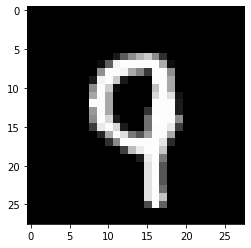

In [7]:
import matplotlib.pyplot as plt
plt.imshow(batch[0][0].permute(1,2,0)[:,:,0], cmap='gray')

In [12]:
epochs = 10
learning_rate = 1e-5
batch = 32
lenet5 = LeNet5()
model = Model(lenet5,learning_rate)
for epoch in tqdm_notebook(range(epochs), desc='Epoch'):
    model.train_step(train_loader)
    model.validation_step(val_loader)
model.test_step(test_loader)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

1.166316407205512 0.4787225755536632
0.49833968382801724 0.5201128829822277
0.3391913942760534 0.23002818974245126
0.217681052466641 0.17432136586303734
0.1540324417384582 0.17192719280749416
0.13156994088677368 0.14505128316226443
0.11695614795242786 0.11970806191156316
0.09942906992010167 0.11229711523869781
0.08874397428221123 0.10705132110031013
0.07745368167203474 0.09607012513921163


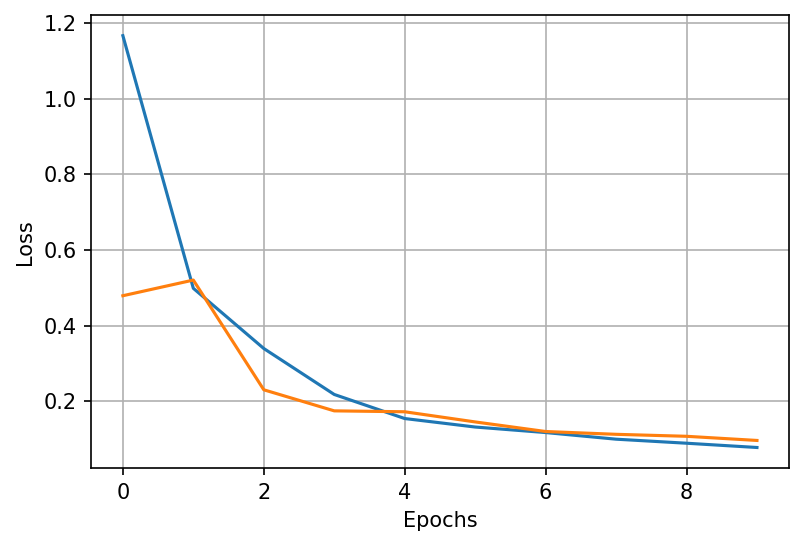

In [79]:
plt.figure(dpi=150)
plt.grid()
plt.plot(model.train_loss)
plt.plot(model.val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("Loss.png")

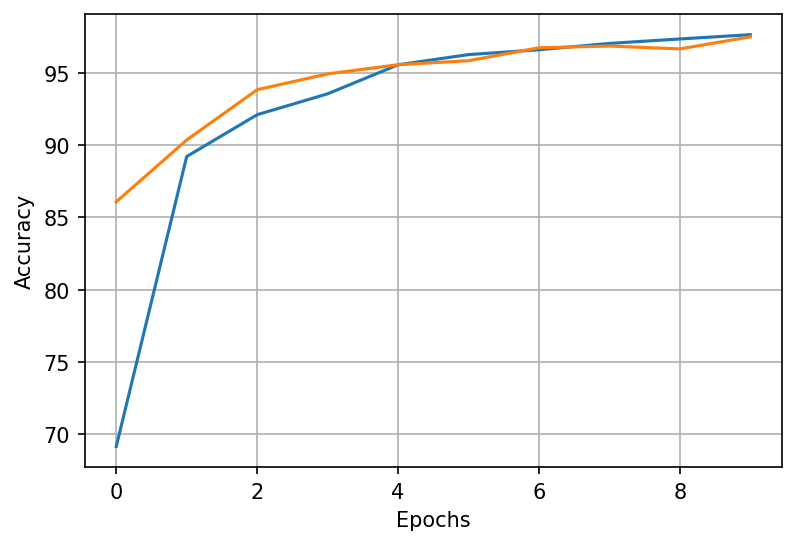

In [78]:
plt.figure(dpi=150)
plt.grid()
plt.plot(model.train_acc)
plt.plot(model.val_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("Accuracy.png")

In [15]:
model.test_step(test_loader)

Accuracy :  97.703674 %
